<a href="https://colab.research.google.com/github/YamenObeidat/Machine-Learning-Final-Project-1/blob/main/edit7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**-----*Data* *Understanding* & *Preprocessing*-----**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve)


In [21]:


drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/orders.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__prior.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__train.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/products.csv.zip" -d /content/

path1 = '/content/drive/MyDrive/' # for the csv files
path2 = '/content/' # for the zip files
def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

aisles = reduce_mem(pd.read_csv(path1 + 'aisles.csv'))
departments = reduce_mem(pd.read_csv(path1 + 'departments.csv'))
products = reduce_mem(pd.read_csv(path2 + 'products.csv'))
'''these two files were so large.
 they took forever to load, so
 i reduced the amount of rows in them. '''
orders = reduce_mem(pd.read_csv(path2 + 'orders.csv' , nrows=1000000 ))
order_products_prior = reduce_mem(pd.read_csv(path2 + 'order_products__prior.csv', nrows=1000000))

order_products_train = reduce_mem(pd.read_csv(path2 + 'order_products__train.csv'))

datasets = {
    "Aisles": aisles,
    "Departments": departments,
    "Products": products,
    "Orders": orders,
    "Prior": order_products_prior,
    "Train": order_products_train
}

for name, df in datasets.items():
    print(f"{name} Columns: {df.columns.tolist()}")

columns = []
for df in datasets.values():
    columns += list(df.columns)

print(f"Number of columns: {len(columns)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/orders.csv.zip
replace /content/orders.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__prior.csv.zip
replace /content/order_products__prior.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__train.csv.zip
replace /content/order_products__train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/products.csv.zip
replace /content/products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Aisles Columns: ['aisle_id', 'aisle']
Departments Columns: ['department_id', 'department']
Products Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']
Orders Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Prior Columns: ['order_id', 'product_i

In [22]:
# I merged products, aisles, and departments into a single products_merged table, to link every product ID to its category name.
products_merged = pd.merge(products, aisles, on='aisle_id', how='inner')
products_merged = pd.merge(products_merged, departments, on='department_id', how='inner')
products_merged = products_merged.drop(['aisle_id', 'department_id'], axis=1)
products_merged.head(10)


,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry
5,6,Dry Nose Oil,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,water seltzer sparkling water,beverages


In [23]:
print(orders.isnull().sum())

''' Essentially when we set nrows to 1 million, the sample contains
60,078 unique customers. the reason this column has more than 60K
missing values is because they are each time a unique customer made
the first purchase. (no previous purchases exist if its the first purchase).
If we ignore the first purchase then: '''

avg_days = orders[orders['order_number'] > 1]['days_since_prior_order'].mean()
print(f"Average days between orders: {avg_days : .2f} days")


order_id                      0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    60078
dtype: int64
Average days between orders:  11.10 days


In [24]:
# First we replace missing values with 0 :
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
print(f"Remaining missing values: {orders["days_since_prior_order"].isnull().sum()}")


Remaining missing values: 0


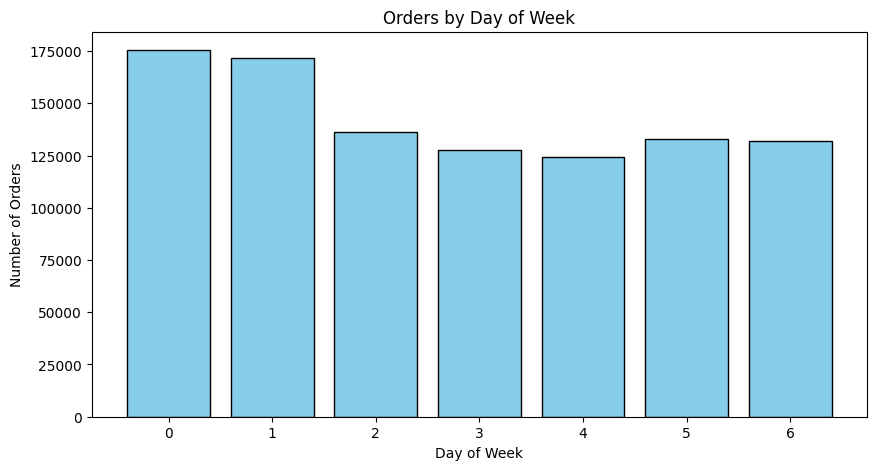

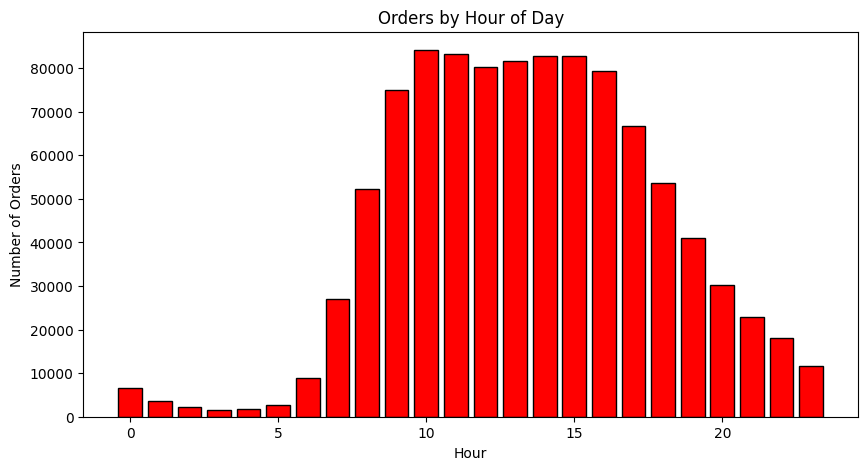

In [25]:
plt.figure(figsize=(10, 5))
day_counts = orders['order_dow'].value_counts().sort_index()
plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.title('Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

plt.figure(figsize=(10, 5))
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values, color='red', edgecolor='black')
plt.title('Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.show()

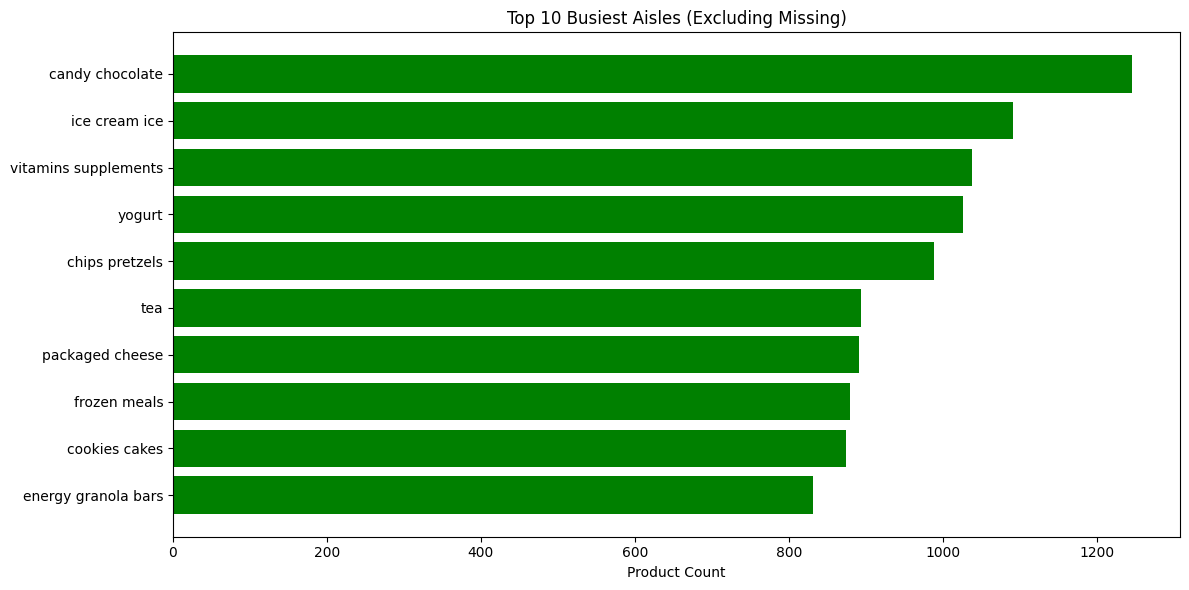

In [26]:
top_aisles = products_merged[products_merged['aisle'] != 'missing']['aisle'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_aisles.index, top_aisles.values, color='green')
plt.gca().invert_yaxis()
plt.title('Top 10 Busiest Aisles (Excluding Missing)')
plt.xlabel('Product Count')
plt.tight_layout()
plt.show()

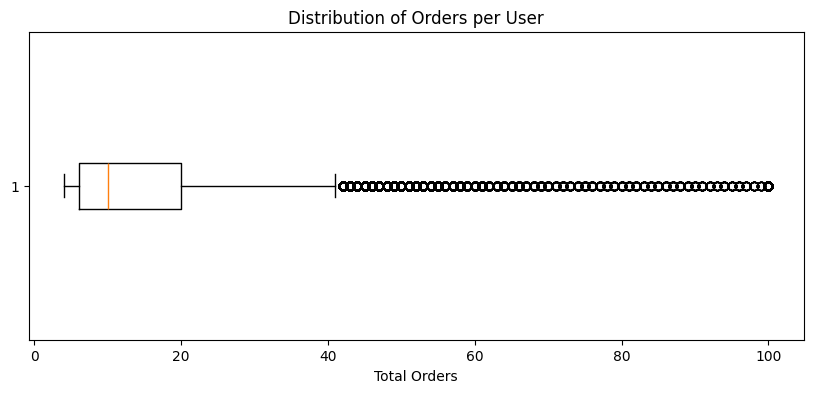

Outlier threshold: 41.0
Total outlier users: 5037


In [27]:
user_orders = orders.groupby('user_id')['order_number'].max()

plt.figure(figsize=(10, 4))
plt.boxplot(user_orders, vert=False)
plt.title('Distribution of Orders per User')
plt.xlabel('Total Orders')
plt.show()

Q1 = user_orders.quantile(0.25)
Q3 = user_orders.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

print(f"Outlier threshold: {upper_limit}")
print(f"Total outlier users: {len(user_orders[user_orders > upper_limit])}")

**-----*Feature* *Engineering* & *Representation*-----**

In [28]:
user_features = orders.groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': ['mean', 'std']
}).reset_index()
user_features.columns = ['user_id', 'user_total_orders', 'user_avg_days_reorder', 'user_std_days_reorder']

product_features = order_products_prior.groupby('product_id').agg({
    'reordered': ['count', 'sum']
}).reset_index()
product_features.columns = ['product_id', 'prod_total_purchases', 'prod_total_reorders']
product_features['prod_reorder_rate'] = product_features['prod_total_reorders'] / product_features['prod_total_purchases']

user_features = user_features.fillna(0)
product_features = product_features.fillna(0)

print(user_features.head())
print(product_features.head())
# هون بلشت أعمل بروفايل لكل مستخدم ولأصناف المنتجات عشان أفهم السيستم كيف الناس بتتسوق.
# بالنسبة للمستخدمين، حسبت كم مرة كل واحد طلب وشو معدل الوقت بين كل طلب والثاني عشان أعرف قديش هم زباين دايمين.
#  و بالنسبة للمنتجات، حسبت مجموع مبيعات كل صنف وطلعت نسبة إعادة الشراءreorder rate عشان أميز الأغراض اللي الناس بترجع تطلبها دايماً.
# fillna(0) وبالآخر استخدمت aعشان أتأكد إنه أي قيمة ناقصة زي لما يكون مستخدم جديد وما إله تاريخ تسوق طويل ما تخربلي الحسابات بالخطوات الجاية.


   user_id  user_total_orders  user_avg_days_reorder  user_std_days_reorder
0        1                 11              17.272728              10.306221
1        2                 15              15.200000              10.751744
2        3                 13              11.076923               5.936631
3        4                  6              14.166667              12.023588
4        5                  5               9.200000               6.978539
   product_id  prod_total_purchases  prod_total_reorders  prod_reorder_rate
0           1                    59                   41           0.694915
1           2                     3                    0           0.000000
2           3                     3                    2           0.666667
3           4                    10                    3           0.300000
4           8                     2                    0           0.000000


In [29]:
# هون دمجت كل اللي عملته قبل بجدول واحد كبير عشان أجهز البيانات للموديل
# ربطت معلومات المستخدمين مع مبيعات المنتجات ومع جدول train الأساسي
# هيك صار عندي صورة كاملة عن كل زبون وشو اشترى وكم مرة كرر العملية بجدول واحد
# وعشان أضمن إنه ما يكون في فراغات بالبيانات حطيت صفر مكان أي قيمة مش موجودة باستخدام fillna(0)

prior_with_user = pd.merge(order_products_prior, orders[['order_id', 'user_id']], on='order_id', how='left')

usr_itm_feat = prior_with_user.groupby(['user_id', 'product_id']).agg({
    'reordered': 'count'
}).reset_index()

usr_itm_feat.columns = ['user_id', 'product_id', 'times_bought']



train_with_user = pd.merge(order_products_train, orders[['order_id', 'user_id']], on='order_id', how='left')


data_final = pd.merge(train_with_user, user_features, on='user_id', how='left')

data_final = pd.merge(data_final, product_features, on='product_id', how='left')

data_final = pd.merge(data_final, usr_itm_feat, on=['user_id', 'product_id'], how='left')


data_final = data_final.fillna(0)

print(data_final.shape)
data_final.head()

(1384617, 12)


,order_id,product_id,add_to_cart_order,reordered,user_id,user_total_orders,user_avg_days_reorder,user_std_days_reorder,prod_total_purchases,prod_total_reorders,prod_reorder_rate,times_bought
0,1,49302,1,1,0.0,0.0,0.0,0.0,4.0,3.0,0.750000,0.0
1,1,11109,2,1,0.0,0.0,0.0,0.0,133.0,86.0,0.646617,0.0
2,1,10246,3,0,0.0,0.0,0.0,0.0,778.0,421.0,0.541131,0.0
3,1,49683,4,0,0.0,0.0,0.0,0.0,2981.0,2045.0,0.686011,0.0
4,1,43633,5,1,0.0,0.0,0.0,0.0,13.0,5.0,0.384615,0.0


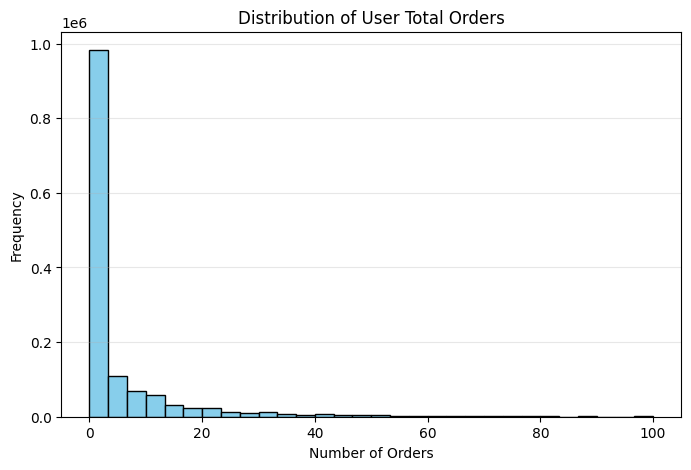

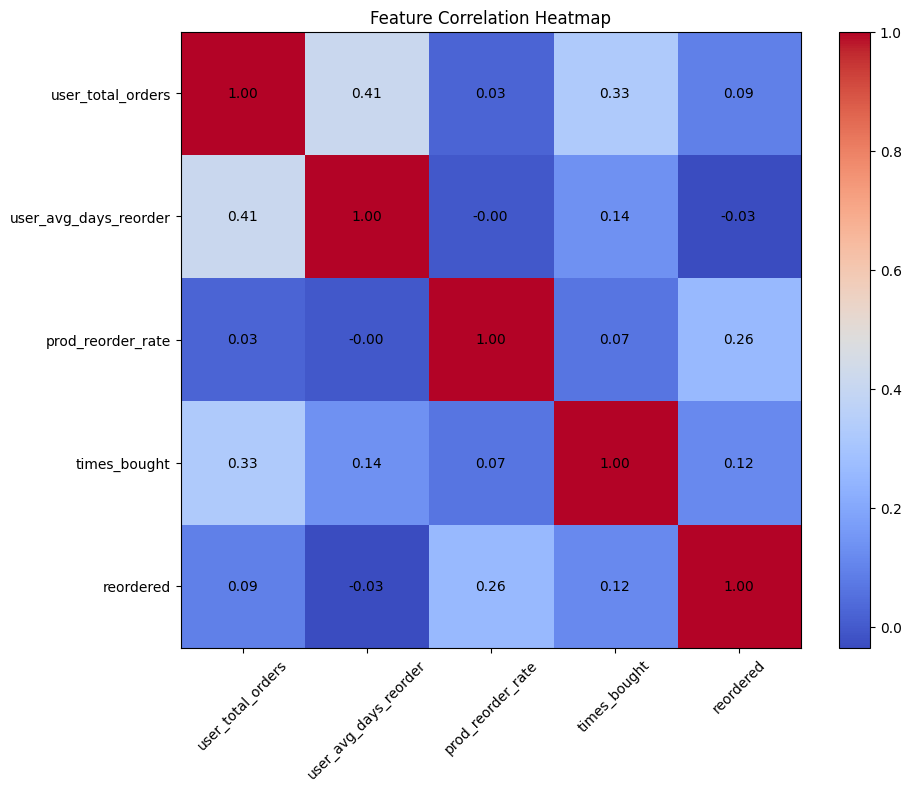

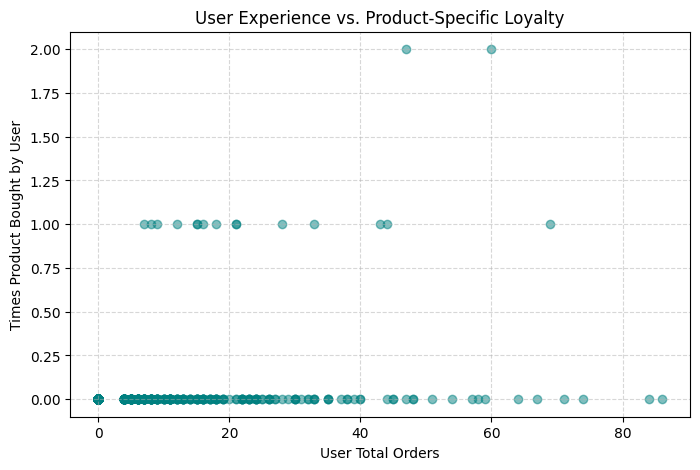

In [30]:
''' I am plotting a histogram to see total orders distribution.
This helps me spot the frequency of power shoppers in our data. '''
plt.figure(figsize=(8, 5))
plt.hist(data_final['user_total_orders'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of User Total Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

''' Here I made a correlation matrix to see relationships.
I used imshow to visualize which featuers link most to the reorder target. '''
corr_cols = ['user_total_orders', 'user_avg_days_reorder', 'prod_reorder_rate', 'times_bought', 'reordered']
corr_matrix = data_final[corr_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()

plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Feature Correlation Heatmap')
plt.show()

''' I created a scatter plot with a 1000 row sample.
I am checking the link between user history and how many times they bought an item. '''
sample_df = data_final.sample(1000)
plt.figure(figsize=(8, 5))
plt.scatter(sample_df['user_total_orders'], sample_df['times_bought'], alpha=0.5, c='teal')
plt.title('User Experience vs. Product-Specific Loyalty')
plt.xlabel('User Total Orders')
plt.ylabel('Times Product Bought by User')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# **TASK B:**